In [1]:
for i in range(1, 1):
    print(i)

In [2]:
from transformers import BertTokenizer
import pandas as pd

def load_data(file_path):
    # 加载数据
    df = pd.read_csv(file_path, delimiter='\t', header=None, names=['question', 'label'])
    input_data = df['question'].tolist()
    labels = df['label'].tolist()
    return input_data, labels

train_data, train_labels = load_data('data/train.txt')
dev_data, dev_labels = load_data('data/dev.txt')
test_data, _ = load_data('data/test.txt')  # 测试集可能没有标签

all_data = train_data + dev_data
all_labels = train_labels + dev_labels

c:\Users\Nxt03\anaconda3\envs\torchfortest\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 类别数量统计

<BarContainer object of 6 artists>

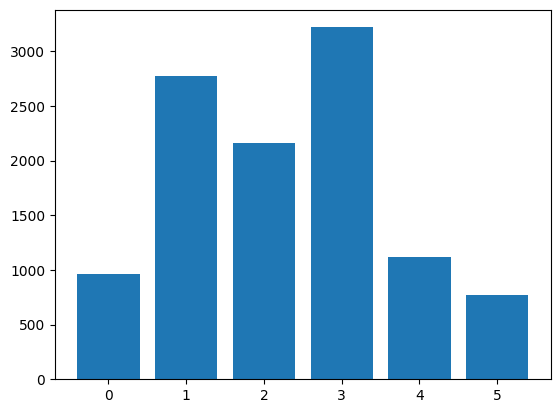

In [3]:
import matplotlib.pyplot as plt

df = pd.DataFrame(all_labels)
label_counts = df.value_counts(sort=False)
# plt.hist(train_labels, bins=6)
plt.bar(x=range(6), height=label_counts.values)

### 文本长度统计

<Axes: ylabel='Density'>

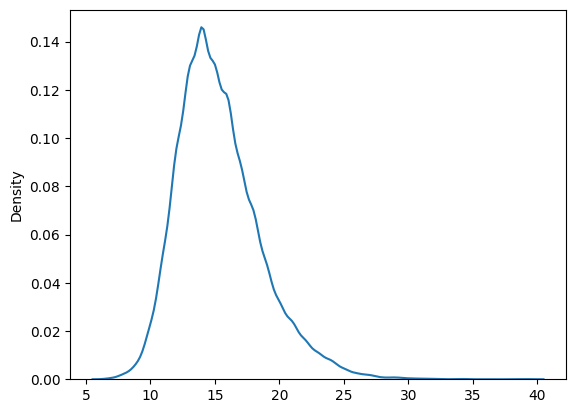

In [4]:
import seaborn as sns
text_len = []
for text in all_data:
    text_len.append(len(text))
# train_len = train_data.apply(len)
sns.kdeplot(text_len)

In [5]:
import numpy as np

np.sum(np.array(text_len) > 27)

28

[0.088      0.25163636 0.19636364 0.29236364 0.10181818 0.06981818]


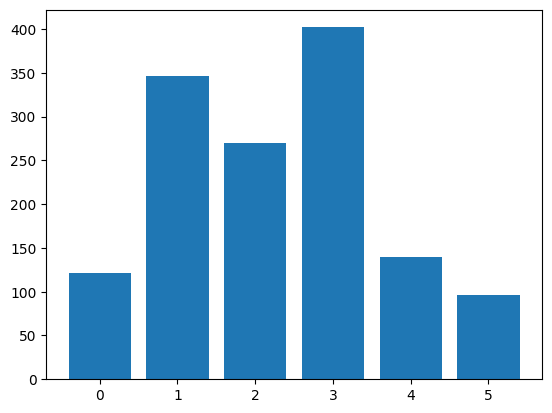

[0.08727273 0.25163636 0.19636364 0.29309091 0.10181818 0.06981818]


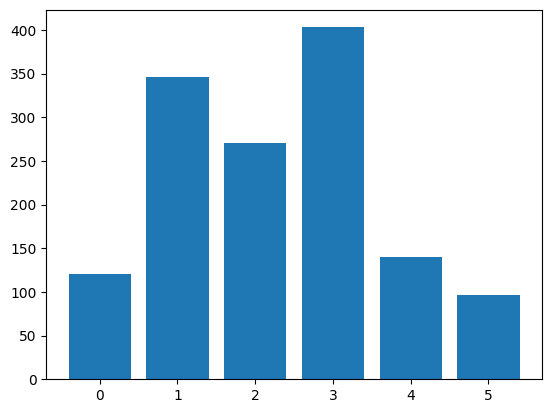

[0.08727273 0.25163636 0.19636364 0.29309091 0.10181818 0.06981818]


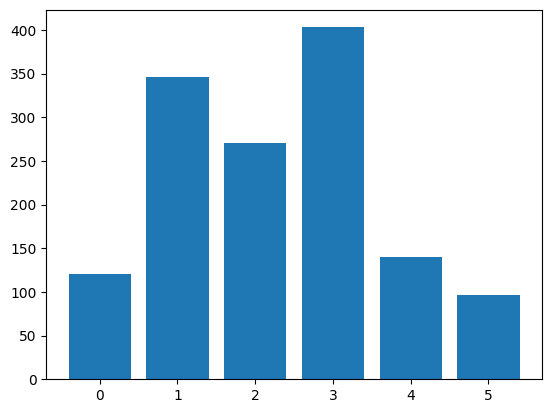

[0.08727273 0.25163636 0.19709091 0.29236364 0.10181818 0.06981818]


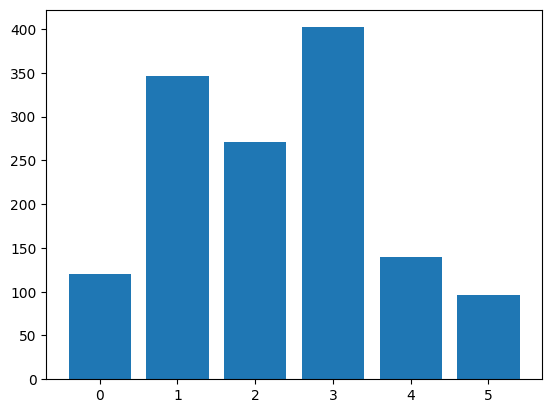

[0.08727273 0.25163636 0.19636364 0.29236364 0.10254545 0.06981818]


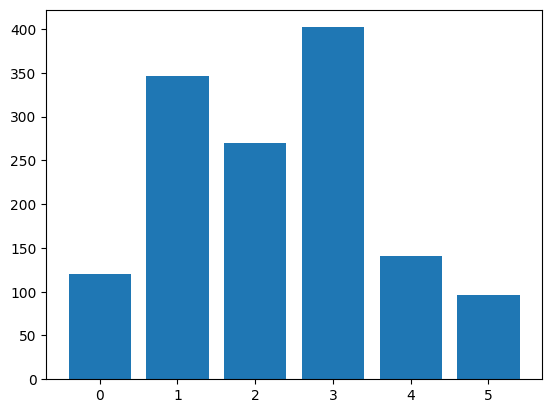

[0.08727273 0.25163636 0.19636364 0.29236364 0.10254545 0.06981818]


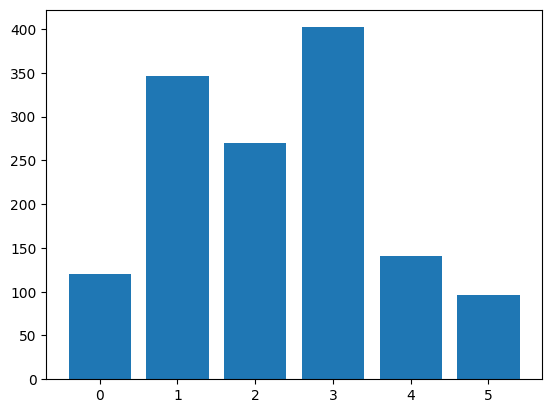

[0.08727273 0.25236364 0.19636364 0.29236364 0.10181818 0.06981818]


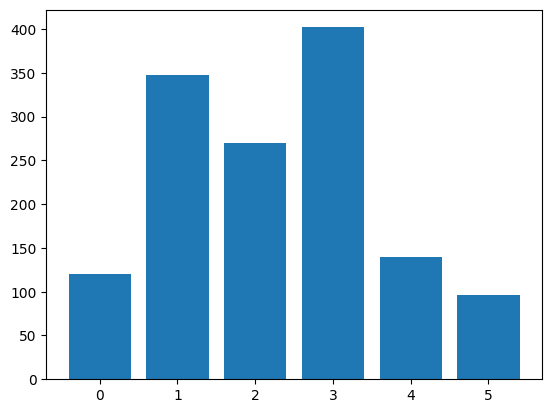

[0.08727273 0.25236364 0.19636364 0.29236364 0.10181818 0.06981818]


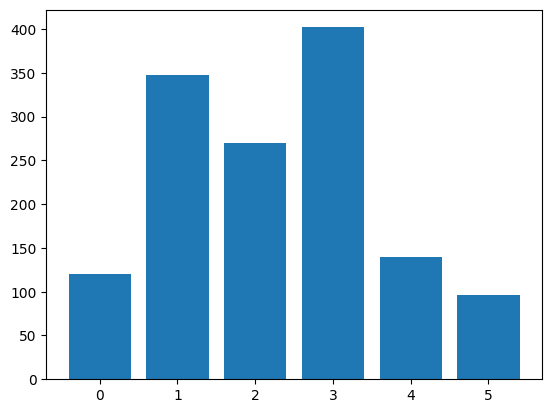

In [6]:
from sklearn.model_selection import KFold, StratifiedKFold
# kf = KFold(n_splits=8, shuffle=True, random_state = 42)
kf = StratifiedKFold(n_splits=8, shuffle=True, random_state = 42)

accuracy_list = []
for train_index, valid_index in kf.split(all_labels, all_labels):
    # print(train_index)
    train_data, val_data = [all_data[i] for i in train_index], [all_data[i] for i in valid_index]
    train_labels, val_labels = [all_labels[i] for i in train_index], [all_labels[i] for i in valid_index]
    df = pd.DataFrame(val_labels)
    label_counts = df.value_counts(sort=False)
    # plt.hist(train_labels, bins=6)
    print(label_counts.values / sum(label_counts.values))
    plt.bar(x=range(6), height=label_counts.values)
    plt.show()

## 数据增强

### AEDA

In [7]:
import random
PUNCTUATIONS = ['.', ',', '!', '?', ';', ':']
PUNC_RATIO = 0.3

def insert_punctuation_marks(sentence, punc_ratio=PUNC_RATIO):
    words = list(sentence)
    new_line = []
    q = random.randint(1, int(punc_ratio * len(words) + 1))
    qs = random.sample(range(0, len(words)), q)


    for j, word in enumerate(words):
        if j in qs:
            new_line.append(PUNCTUATIONS[random.randint(0, len(PUNCTUATIONS)-1)])
            new_line.append(word)
        else:
            new_line.append(word)

    new_line = ''.join(new_line)
    return new_line

insert_punctuation_marks(train_data[0])

'空腹血糖7!8，是.否:属于糖?尿病范围?'

In [8]:
def AEDA(file_path):
    # 读取原始数据
    with open(f'{file_path}.txt', 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # 创建新的训练数据文件
    with open(f'{file_path}_new.txt', 'w', encoding='utf-8') as f_new:
        for index, line in enumerate(lines):
            # if index == 20: break
            # print(line.strip().split())
            question, label = line.strip().split()  # 假设每行的格式为 "question label"

            # 生成新句子
            new_questions = []
            for i in range(1):
                new_question = insert_punctuation_marks(question)
                # print(new_question)
                new_questions.append(new_question)

            # 将原始句子和相似句写入新文件
            for new_question in new_questions:
                f_new.write(f"{new_question}\t{label}\n")

# AEDA('data/train')
AEDA('data/dev')

### 回译生成相似数据

In [10]:
import urllib.request
import urllib.parse
import json
import requests  # pip intasll requests
import execjs  # 安装指令：pip install PyExecJS
import random
import hashlib
import re
import time

# 百度翻译方法
def baidu_translate(content, t_from, t_to, appid='20240312001991246', secretKey='kGTBEj_db53PulgNBGTL'):
    # print(content)
    if len(content) > 4891:
        return '输入请不要超过4891个字符！'
    salt = str(random.randint(0, 50))
    # 申请网站 http://api.fanyi.baidu.com/api/trans
    sign = appid + content + salt + secretKey
    sign = hashlib.md5(sign.encode(encoding='UTF-8')).hexdigest()
    head = {'q': f'{content}',
            'from': f'{t_from}',
            'to': f'{t_to}',
            'appid': f'{appid}',
            'salt': f'{salt}',
            'sign': f'{sign}'}
    # print(head)
    j = requests.get('https://fanyi-api.baidu.com/api/trans/vip/translate', head)
    # print(j.json())
    res = j.json()['trans_result'][0]['dst']
    res = re.compile('[\\x00-\\x08\\x0b-\\x0c\\x0e-\\x1f]').sub(' ', res)
    # print(res)
    return res

ret = baidu_translate(content="只因你太美", t_from='zh', t_to='en')
time.sleep(0.1)
ret = baidu_translate(content=ret, t_from='en', t_to='zh')
print(ret)

就因为你太漂亮了
